In [1]:
from cell_env import CellEnv
from stable_baselines3 import DQN
import matplotlib.pyplot as plt
import numpy as np

from gymnasium.wrappers import TimeLimit
from plot_utils import plot_observations, evaluate_model, plot_actions


In [2]:
# Load the best model from rl-models:
# # model = DQN.load("rl-models-sde/best_model.zip")
# model = DQN.load(".sweep-models/woven-sweep-17/best_model.zip")
# model = DQN.load(".sweep-models/toasty-sweep-35/best_model.zip")
# model = DQN.load(".sweep-models/decent-sweep-88/best_model.zip")

In [14]:
# Example usage:

env_args = {
    "max_timesteps": 60,
    "alpha_mem": 0.7,
    "dt": 0.1,
    "frame_stack": 30,
}
model_str = ".sweep-models/stoic-sweep-33/best_model.zip"
# model_str = ".sweep-models/toasty-sweep-35/best_model.zip"
eval_env = CellEnv(**env_args)
all_obs, all_actions = evaluate_model(env_args, 20, model_str, multiprocess=True)


In [15]:
unif_obs, unif_actions = evaluate_model(env_args, 20, multiprocess=True)

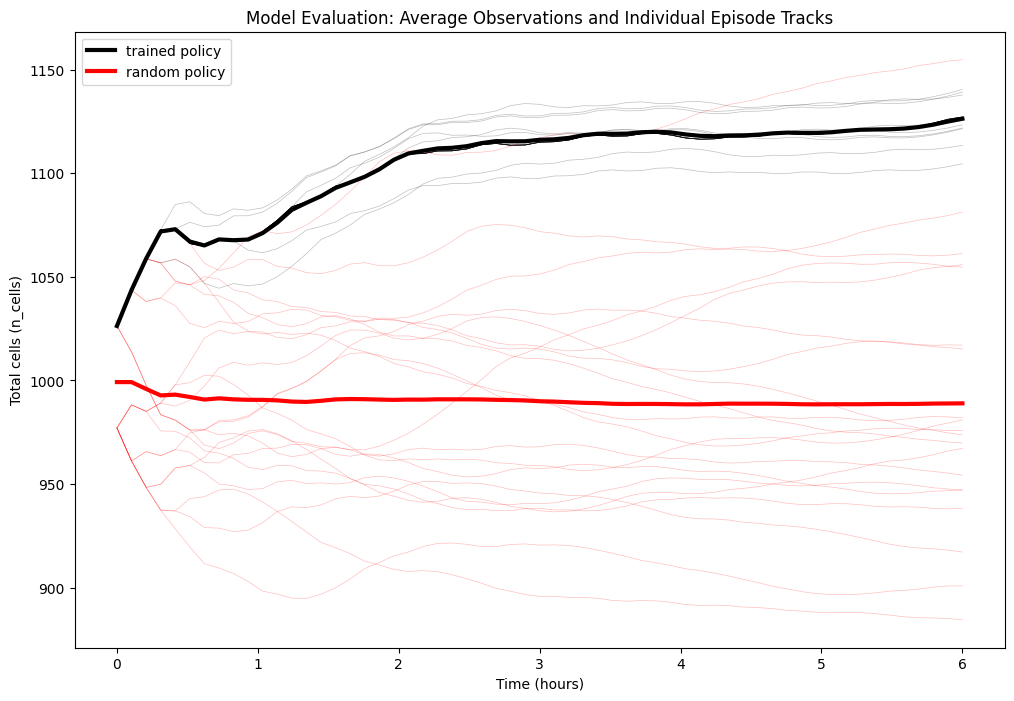

In [17]:
plot_observations(env_args, all_obs, unif_obs, alpha_val=0.25)

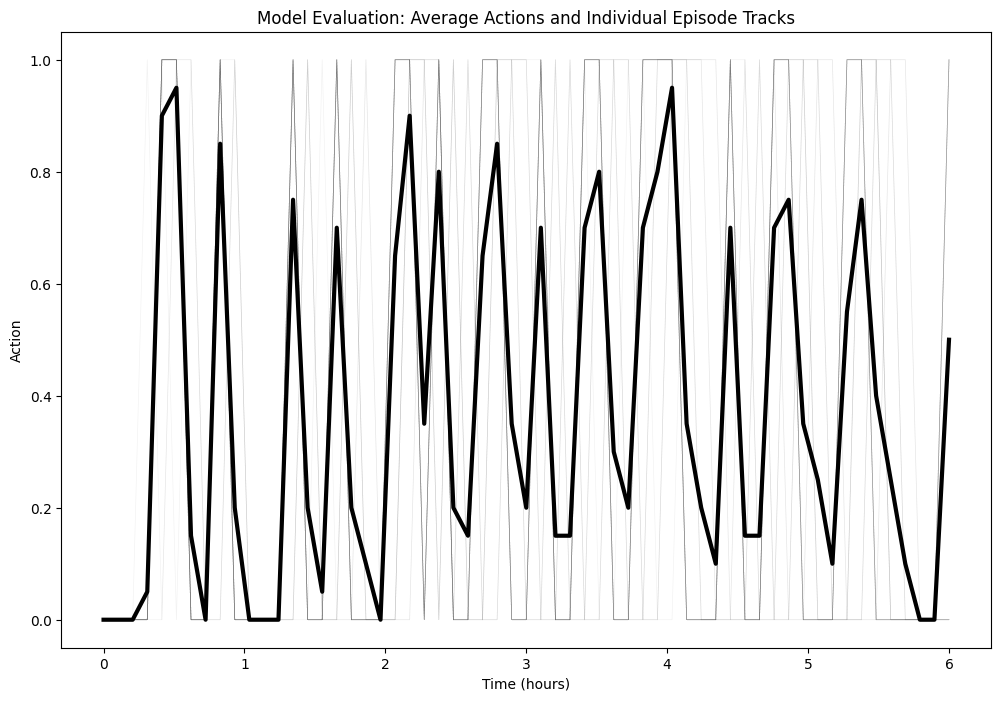

In [18]:
plot_actions(env_args, all_actions)

In [8]:
# bin the actions and plot average frequency in each bin over time:
avg_actions = np.array(avg_actions)
freqs=[]
time_chunks = 10
for i in range(time_chunks):
    interval = len(avg_actions)//time_chunks
    action_subset = avg_actions[interval*i:interval*(i+1)]
    # Do FT and get max frequency
    action_subset = action_subset - np.mean(action_subset)
    action_subset = np.abs(np.fft.fft(action_subset))
    action_subset = action_subset[:len(action_subset)//2]
    freqs.append(np.argmax(action_subset))
plt.plot(freqs)


NameError: name 'avg_actions' is not defined